In [1]:
import torch
torch.set_default_dtype(torch.float64)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [2]:
# Orthonormal basis of SO(3) with shape [3, 3, 3]
basis = torch.tensor([
    [[0.,0.,0.],[0.,0.,-1.],[0.,1.,0.]],
    [[0.,0.,1.],[0.,0.,0.],[-1.,0.,0.]],
    [[0.,-1.,0.],[1.,0.,0.],[0.,0.,0.]]])

# hat map from vector space R^3 to Lie algebra so(3)
def hat(v): return torch.einsum('...i,ijk->...jk', v, basis)

# Logarithmic map from SO(3) to R^3 (i.e. rotation vector)
def Log(R): return torch.tensor(Rotation.from_matrix(R.numpy()).as_rotvec())
    
# logarithmic map from SO(3) to so(3), this is the matrix logarithm
def log(R): return hat(Log(R))

# Exponential map from so(3) to SO(3), this is the matrix exponential
def exp(A): return torch.linalg.matrix_exp(A)

# Exponential map from tangent space at R0 to SO(3)
def expmap(R0, tangent):
    skew_sym = torch.einsum('...ij,...ik->...jk', R0, tangent)
    return torch.einsum('...ij,...jk->...ik', R0, exp(skew_sym))

# Return angle of rotation. SO(3) to R^+
def Omega(R): return torch.arccos((torch.diagonal(R, dim1=-2, dim2=-1).sum(axis=-1)-1)/2)

# Power series expansion in the IGSO3 density.
def f_igso3(omega, t, L=500):
    ls = torch.arange(L)[None]  # of shape [1, L]
    return ((2*ls + 1) * torch.exp(-ls*(ls+1)*t/2) *
             torch.sin(omega[:, None]*(ls+1/2)) / torch.sin(omega[:, None]/2)).sum(dim=-1)

# IGSO3(Rt; I_3, t), density with respect to the volume form on SO(3) 
def igso3_density(Rt, t, L=500): return f_igso3(Omega(Rt), t, L)

In [3]:
# Sample N times from U(SO(3)) by inverting CDF of uniform distribution of angle 
def p_inv(N, M=1000):
    omega_grid = np.linspace(0, np.pi, M)
    cdf = np.cumsum(np.pi**-1 * (1-np.cos(omega_grid)), 0)/(M/np.pi)
    omegas = np.interp(np.random.rand(N), cdf, omega_grid)
    axes = np.random.randn(N, 3)
    axes = omegas[:, None]* axes/np.linalg.norm(axes, axis=-1, keepdims=True)
    return exp(hat(torch.tensor(axes)))

## Define discrete target measure on SO(3), and it's score for t>0
N_atoms = 3
mu_ks = p_inv(N_atoms) # Atoms defining target measure

# Sample p_0 ~ (1/N_atoms)\sum_k Dirac_{mu_k}
def p_0(N): return mu_ks[torch.randint(mu_ks.shape[0], size=[N])] 

# Density of discrete target noised for time t
def p_t(Rt, t): return sum([
        igso3_density(torch.einsum('ji,...jk->...ik', mu_k, Rt), t)
        for mu_k in mu_ks])/N_atoms

# Riemannian gradient of f at R
def riemannian_gradient(f, R):
    coefficients = torch.zeros(list(R.shape[:-2])+[3], requires_grad=True)
    R_delta = expmap(R, torch.einsum('...ij,...jk->...ik', R, hat(coefficients)))
    grad_coefficients = torch.autograd.grad(f(R_delta).sum(), coefficients)[0]
    return torch.einsum('...ij,...jk->...ik', R, hat(grad_coefficients))

# Stein score of p_t
def score_t(Rt, t): return riemannian_gradient(lambda R_: torch.log(p_t(R_, t)), Rt)

# Normal sample in tangent space at R0
def tangent_gaussian(R0): return torch.einsum('...ij,...jk->...ik', R0, hat(torch.randn(R0.shape[0], 3)))

# Simluation procedure for forward and reverse
def geodesic_random_walk(p_initial, drift, ts):
    Rts = {ts[0]:p_initial()}
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # negative for reverse process
        Rts[ts[i]] = expmap(Rts[ts[i-1]],
            drift(Rts[ts[i-1]], ts[i-1]) * dt + tangent_gaussian(Rts[ts[i-1]]) * np.sqrt(abs(dt)))
    return Rts

In [4]:
N = 1000 # Number of samples
T = 4. # Final time 
ts = np.linspace(0, T, 200) # Discretization of [0, T]
forward_samples = geodesic_random_walk(
    p_initial=lambda: p_0(N), drift=lambda Rt, t: 0., ts=ts)
reverse_samples = geodesic_random_walk(
    p_initial=lambda: p_inv(N), drift=lambda Rt, t: -score_t(Rt, t), ts=ts[::-1])

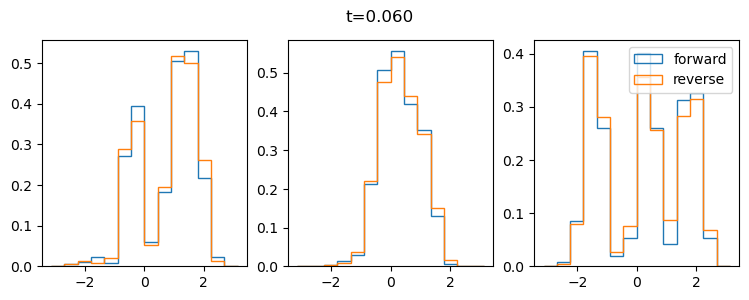

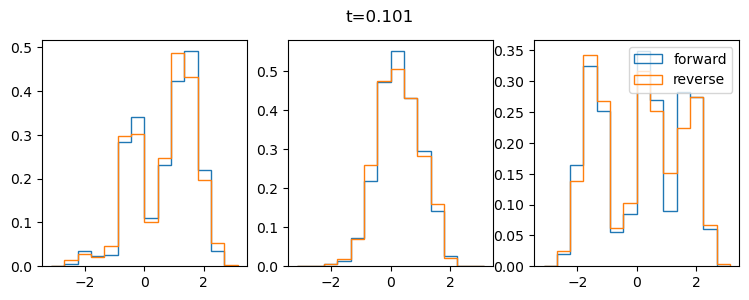

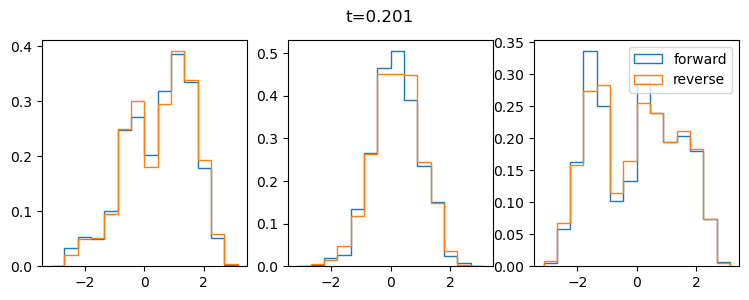

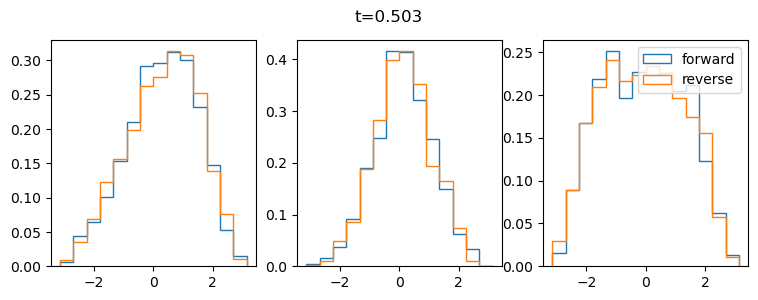

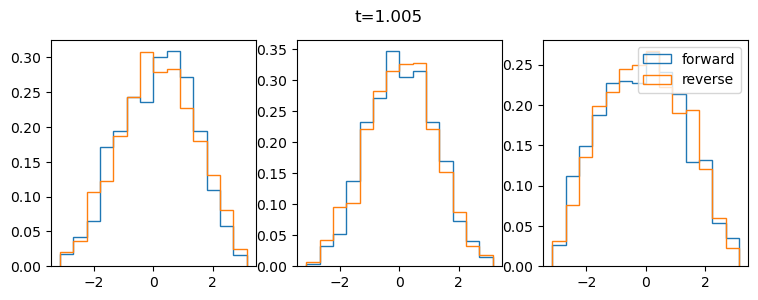

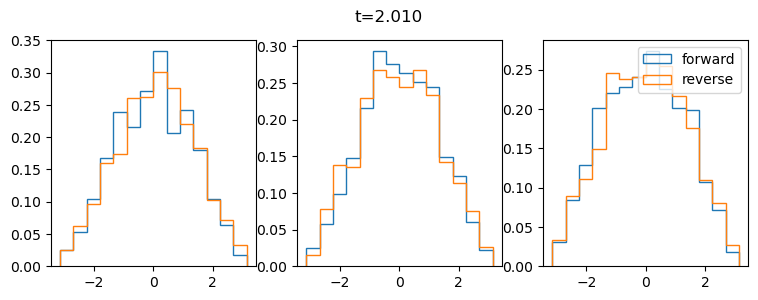

In [7]:
# Plot comparison of forward and reverse process
for i in [3, 5, 10, 25, 50, 100]:
    t = ts[i]
    Rt_forward = Log(forward_samples[ts[i]])
    Rt_reverse = Log(reverse_samples[ts[i]])
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(9, 3))
    fig.suptitle(f't={t:.3f}')
    bins = np.linspace(-np.pi, np.pi, 15)
    for Rt, label in [(Rt_forward, "forward"), (Rt_reverse, "reverse")]:
        for i in range(3): axs[i].hist(Rt[:, i].numpy(), bins, density=True, histtype='step', label=label)
    plt.legend()